In [1]:
"""
Agent for Move to Beacon minimap of Spacecraft II 
"""
from pysc2.agents import base_agent
from pysc2.lib import actions
from pysc2.env import sc2_env
from pysc2.lib import actions, features
import time
import random
from collections import deque
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.keras.utils.disable_interactive_logging()
PLAYER_NEUTRAL = features.PlayerRelative.NEUTRAL  
BATCH_SIZE = 64
FUNCTIONS = actions.Functions
LEARNING_SIZE = 100
MEMORY_SIZE = 100000
FUNCTIONS = actions.FUNCTIONS

class MoveToBeacon(base_agent.BaseAgent):
    def __init__(self, exploration_rate=0.5, exploration_decay = 0.99, learning_rate=0.001):
        """
        The constructor method to iniliase parameters and build the separate neural network models for action and location 
        """
        super(MoveToBeacon, self).__init__()

        self.memory = deque(maxlen = MEMORY_SIZE)
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.learning_rate = learning_rate

        self.observation_space = 7640
        self.action_space = 3
        self.location_space = 2

        # build the model
        initializer = tf.keras.initializers.GlorotNormal()

        self.action_model = tf.keras.models.Sequential([
        layers.Dense(128, input_shape=(self.observation_space,), activation="linear", kernel_initializer=initializer),
        layers.Dense(128, activation="linear", kernel_initializer=initializer),
        layers.Dense(self.action_space, activation="softmax")
        ])

        self.action_model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
        )

        self.action_model.summary()
        
        self.location_model = tf.keras.models.Sequential([
        layers.Dense(128, input_shape=(self.observation_space,), activation="relu", kernel_initializer=initializer),
        layers.Dense(128, activation="relu", kernel_initializer=initializer),
        layers.Dense(self.location_space, activation="linear")
        ])


        self.location_model.compile(
            loss="mean_squared_error",
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
        )            
        
        self.location_model.summary()

    def step(self, obs):
        super(MoveToBeacon, self).step(obs)

        if (np.random.rand() <= self.exploration_rate):
            return self.explore_step(obs)
        else:
            return self.model_step(obs)

    def model_step(self, obs):
        """
        Outputs one of the three actions - no_op, select_army, move_screen - based on the q-values predicted by the model 
        """

        action = ""
        current_state = self.get_state(obs)
        current_state = np.array(current_state).reshape(-1, self.observation_space)
        model_output = self.action_model.predict(current_state)
        current_action = np.argmax(model_output)

        if current_action == 0:
            action = FUNCTIONS.no_op()
            curr_action_id = 0

        elif current_action == 1:
            action = FUNCTIONS.select_army("select")
            curr_action_id = 7
        else:
            loc = self.location_model.predict(current_state)

            loc_x = int(loc[0][0])
            loc_y = int(loc[0][1])

            if loc_x < 0 or loc_x > 83:
                loc_x = 0
            if loc_y < 0 or loc_y > 83:
                loc_y = 0
                
            action = FUNCTIONS.Move_screen("now", [loc_x, loc_y])
            curr_action_id = 331

        if curr_action_id not in obs.observation.available_actions:
            action = FUNCTIONS.no_op()
            current_action = 0
            curr_action_id = 0

        return action

    def explore_step(self, obs):

        if FUNCTIONS.Move_screen.id in obs.observation.available_actions:
            player_relative = obs.observation.feature_screen.player_relative
            mask = player_relative == PLAYER_NEUTRAL
            y, x = mask.nonzero()
            beacon = list(zip(x, y))

            if not beacon:
                return FUNCTIONS.no_op()
            
            beacon_center = np.mean(beacon, axis=0).round()
            return FUNCTIONS.Move_screen("now", beacon_center)
        else:
            return FUNCTIONS.select_army("select")

    def get_state (self, obs):
        the_state = []

        action_list = obs.observation.available_actions.tolist()

        state_actions = [0 for i in range(573)]
        for action in action_list:
            state_actions[action] = 1

        #player relative array
        state_player_rel = [
            item for sublist in obs.observation.feature_screen.player_relative.tolist()
            for item in sublist
        ]
        state_player = obs.observation["player"].tolist()
        
        the_state = state_actions + state_player_rel + state_player
        return the_state

    
    def record_experience (self, curr_obs, action, reward, next_obs):
        state = self.get_state(curr_obs)
        next_state = self.get_state(next_obs)

        player_relative = curr_obs.observation.feature_screen.player_relative

        mask = player_relative == PLAYER_NEUTRAL
        y, x = mask.nonzero()
        beacon = list(zip(x, y))

        if not beacon:
            beacon_location = [0,0]
        else:
            beacon_location = np.mean(beacon, axis=0).round()

        action_code = int(str(FUNCTIONS[action[0]]).split("/")[0])
        if  action_code == 0:
            simp_action = [1.0,0.0,0.0]
        elif action_code == 7:
            simp_action = [0.0, 1.0, 0.0]
        elif action_code == 331:
            simp_action = [0.0, 0.0, 1.0]
        else:
            simp_action = [0.0, 0.0, 0.0]        

        self.memory.append([state, simp_action, beacon_location, reward, next_state])

    def train(self):
        """
        Fit the models once there is enough data
        """
        if len(self.memory) < LEARNING_SIZE:
            return
        
        if random.randint(0,100) < 90:
            return

        # pick random data from all saved data to use to improve the model
        batch = random.sample(self.memory, LEARNING_SIZE)
        X = []
        action_y = []
        location_y = []

        start_time = time.time()

        for st, actn, bl, rewd, ns in batch:
            X.append(st)
            action_y.append(actn)
            location_y.append(bl)

        # update the model
        X = np.array(X).reshape(-1, self.observation_space)
        action_y = np.array(action_y).reshape(-1, self.action_space)
        location_y = np.array(location_y).reshape(-1, self.location_space)

        self.action_model.fit(X, action_y, batch_size=BATCH_SIZE, epochs=5, verbose=0)
        
        self.location_model.fit(X, location_y, batch_size=BATCH_SIZE, epochs=5, verbose=0)

        # update the exploration rate
        self.exploration_rate *= self.exploration_decay

    def save_model(self):
        # save the models for each episode for evaluation later
        self.action_model.save("action.keras")
        self.location_model.save("location.keras")


pygame 2.6.0 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\Arun\anaconda3\envs\SC2_VENV\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cumulative score for episode 1: 9
Cumulative score for episode 2: 14
Cumulative score for episode 3: 20
Cumulative score for episode 4: 24
Cumulative score for episode 5: 23
Test score: 23


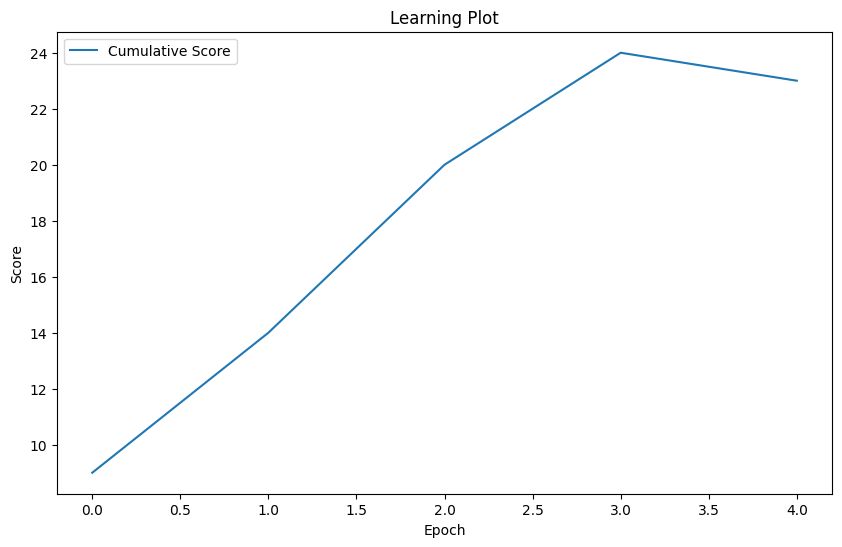

In [2]:
from absl import flags
import sys

def setup_env():
    env = sc2_env.SC2Env(
    map_name="MoveToBeacon",
    players=[sc2_env.Agent(sc2_env.Race.terran)],
    agent_interface_format=features.AgentInterfaceFormat(
        feature_dimensions=features.Dimensions(screen=84, minimap=64),
        use_feature_units=True
    ),
    step_mul=8,
    game_steps_per_episode=0, # no time limit
    visualize=True
    )
    
    return env


def main():
    # Parse flags before creating the environment
    FLAGS = flags.FLAGS
    FLAGS(sys.argv[:1])  # Only parse the first argument (the script name)

    # Create an instance of your agent
    agent = MoveToBeacon()

    # Set up environment 
    env = setup_env()
    
    # set number of episodes 
    num_episodes = 5

    scores = []

    try:
        for episode in range(num_episodes):  
            agent.setup(env.observation_spec(), env.action_spec())
            obs = env.reset()

            while True:
                step_actions = [agent.step(obs[0])]
                acts = step_actions[0]
                
                if obs[0].last():
                    print(f"Cumulative score for episode {episode+1}: {obs[0].observation.score_cumulative[0]}")
                    scores.append(obs[0].observation.score_cumulative[0])
                    break
                
                if acts[0] not in obs[0].observation.available_actions:
                    step_actions = [FUNCTIONS.no_op()]
            
                next_obs = env.step(step_actions) # next observation
                agent.record_experience(obs[0], acts, obs[0].reward, next_obs[0]) # pass S, A, R, R'

                obs = next_obs
                agent.train()

    finally:
        env.close()

    agent.save_model()

    # Test the model

    env = setup_env()

    try:
        agent.setup(env.observation_spec(), env.action_spec())
        obs = env.reset()

        while True:
            step_actions = [agent.step(obs[0])]
            acts = step_actions[0]
            
            if obs[0].last():
                print(f"Test score: {obs[0].observation.score_cumulative[0]}")
                break
            
            if acts[0] not in obs[0].observation.available_actions:
                step_actions = [FUNCTIONS.no_op()]
        
            next_obs = env.step(step_actions) # next observation
            obs = next_obs


    finally:
        env.close()
        
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label='Cumulative Score')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    
if __name__ == "__main__":
    main()
